In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.preprocessing import LabelEncoder

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

# **Read the data and get some info**

In [2]:
df = pd.read_excel(r"D:\AirportTickets_price_prediction\Airport.xlsx")
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [4]:
df.isnull().sum()

Airline            0
Date_of_Journey    0
Source             0
Destination        0
Route              1
Dep_Time           0
Arrival_Time       0
Duration           0
Total_Stops        1
Additional_Info    0
Price              0
dtype: int64

In [5]:
df.nunique()

Airline              12
Date_of_Journey      44
Source                5
Destination           6
Route               128
Dep_Time            222
Arrival_Time       1343
Duration            368
Total_Stops           5
Additional_Info      10
Price              1870
dtype: int64

# **Changing data format** 

### Get the day and the month of the journey

In [6]:
df["Date_of_Journey"] = pd.to_datetime(df["Date_of_Journey"], format="%d/%m/%Y",dayfirst=True)
df['Journey Month'] = df["Date_of_Journey"].dt.month_name()
df['Journey day'] = df["Date_of_Journey"].dt.day_name()

### Get the duration of journey in hours and in min 

In [7]:
df[["Hours","Min"]]=df.Duration.str.split(" ",expand=True)
df['Hours'].fillna(0, inplace=True)
df["Min"].fillna(0,inplace=True)
df["Total_Stops"].fillna("1 stop",inplace=True)

In [8]:
df['time_in_minutes'] = pd.to_timedelta(df['Hours']).dt.total_seconds() / 60
df["_minutes"] = pd.to_timedelta(df['Min']).dt.total_seconds() / 60
df["Duration in min"] = df["time_in_minutes"] + df["_minutes"]

### Convert months to seasons 

In [9]:
def determine_season(date):
    month = date.month
    if month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    elif month in [9, 10, 11]:
        return 'Autumn'
    else:
        return 'Winter'
df['season'] = df['Date_of_Journey'].apply(determine_season)

### Get the dep hours and min 

In [10]:
df[['dep_hours', 'dep_minutes']] = df['Dep_Time'].str.split(':', expand=True).astype(int)

In [11]:
df = df.drop(columns=["time_in_minutes","_minutes"])
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey Month,Journey day,Hours,Min,Duration in min,season,dep_hours,dep_minutes
0,IndiGo,2019-03-24,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897,March,Sunday,2h,50m,170.0,Spring,22,20
1,Air India,2019-05-01,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662,May,Wednesday,7h,25m,445.0,Spring,5,50
2,Jet Airways,2019-06-09,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882,June,Sunday,19h,0,1140.0,Summer,9,25
3,IndiGo,2019-05-12,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218,May,Sunday,5h,25m,325.0,Spring,18,5
4,IndiGo,2019-03-01,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302,March,Friday,4h,45m,285.0,Spring,16,50


In [12]:
df.nunique()

Airline              12
Date_of_Journey      40
Source                5
Destination           6
Route               128
Dep_Time            222
Arrival_Time       1343
Duration            368
Total_Stops           5
Additional_Info      10
Price              1870
Journey Month         4
Journey day           7
Hours                44
Min                  12
Duration in min     368
season                2
dep_hours            24
dep_minutes          12
dtype: int64

In [13]:
df.describe()

,Date_of_Journey,Price,Duration in min,dep_hours,dep_minutes
count,10683,10683.000000,10683.000000,10683.000000,10683.000000
mean,2019-05-04 19:56:41.853412096,9087.064121,643.093232,12.490686,24.411214
min,2019-03-01 00:00:00,1759.000000,5.000000,0.000000,0.000000
25%,2019-03-27 00:00:00,5277.000000,170.000000,8.000000,5.000000
50%,2019-05-15 00:00:00,8372.000000,520.000000,11.000000,25.000000
75%,2019-06-06 00:00:00,12373.000000,930.000000,18.000000,40.000000
max,2019-06-27 00:00:00,79512.000000,2860.000000,23.000000,55.000000
std,NaN,4611.359167,507.862001,5.748650,18.767980


# **EDA**

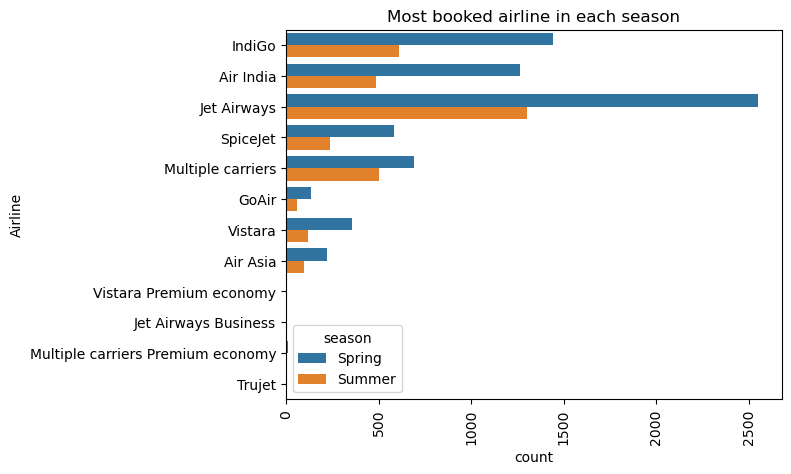

In [14]:
sns.countplot(data = df,y = "Airline",hue="season");
plt.xticks(rotation=90);
plt.title("Most booked airline in each season");

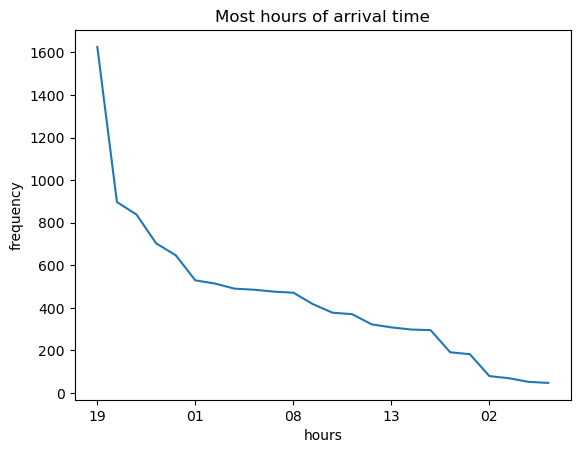

In [15]:
df['Arrival_Time'].str[:2].value_counts().plot(kind='line')
plt.xlabel('hours')
plt.ylabel('frequency')
plt.title("Most hours of arrival time");

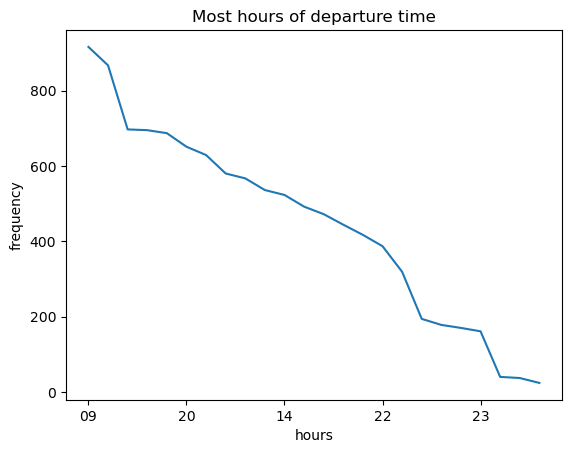

In [16]:
df['Dep_Time'].str[:2].value_counts().plot(kind='line')
plt.xlabel('hours')
plt.ylabel('frequency')
plt.title("Most hours of departure time");

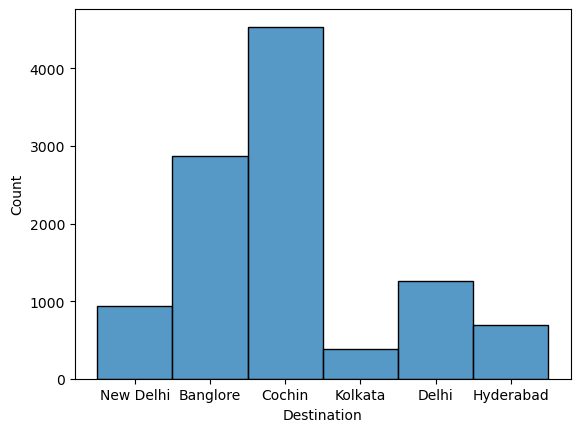

In [17]:
sns.histplot(data = df,x = "Destination");

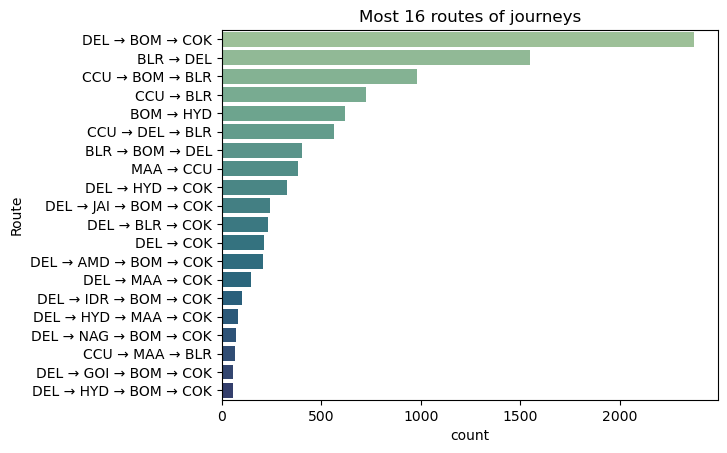

In [18]:
chart=sns.countplot(y='Route',data=df,palette='crest', order = df['Route'].value_counts()[:20].index)
plt.title("Most 16 routes of journeys");

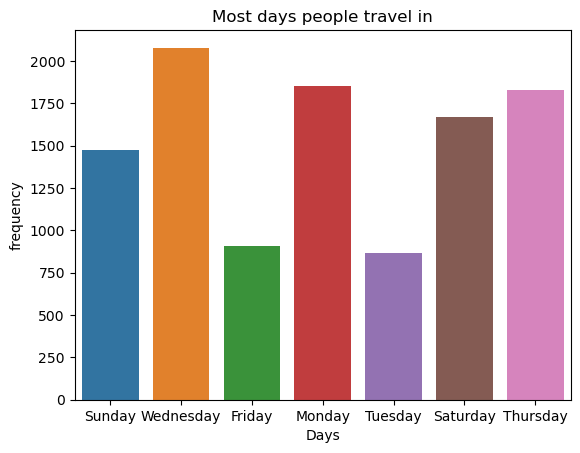

In [19]:
sns.countplot(data = df,x = 'Journey day');
plt.xlabel('Days')
plt.ylabel('frequency')
plt.title("Most days people travel in");

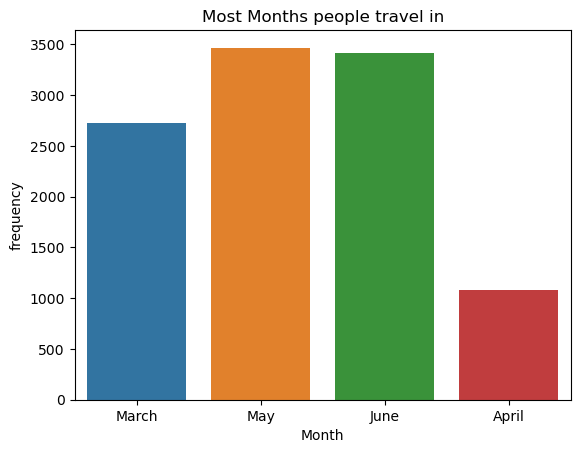

In [20]:
sns.countplot(data=df,x = "Journey Month");
plt.xlabel('Month')
plt.ylabel('frequency')
plt.title("Most Months people travel in");

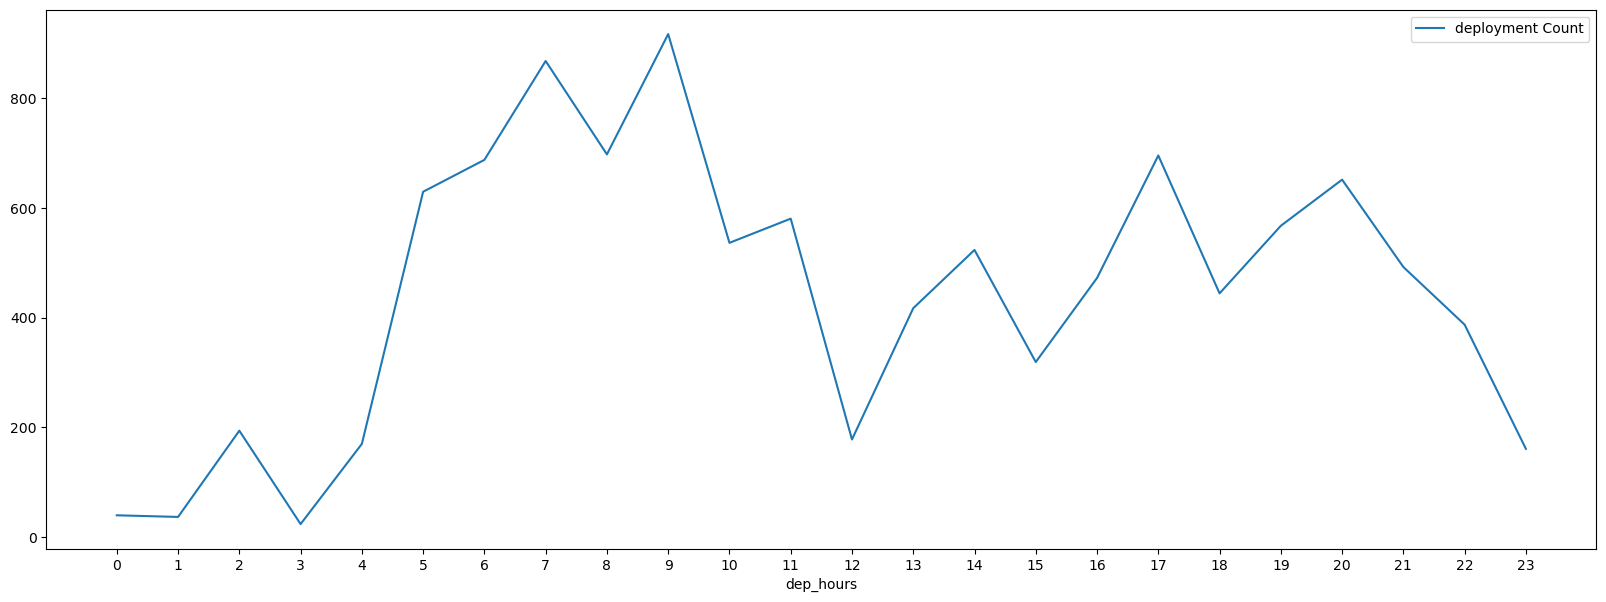

In [21]:
hours_count= df["dep_hours"].value_counts().sort_index()

plt.figure(figsize=(20, 7))
sns.lineplot(x=hours_count.index, y=hours_count.values, label='deployment Count')
plt.xticks(range(0,24));

# **Data preprocessing**

In [22]:
label_encoder = LabelEncoder()
df['Total_Stops'] = label_encoder.fit_transform(df['Total_Stops'])
df["Journey day"] = label_encoder.fit_transform(df["Journey day"])
df["Destination"] = label_encoder.fit_transform(df["Destination"])
df["season"] = label_encoder.fit_transform(df["season"])

In [23]:
df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price,Journey Month,Journey day,Hours,Min,Duration in min,season,dep_hours,dep_minutes
0,IndiGo,2019-03-24,Banglore,5,BLR → DEL,22:20,01:10 22 Mar,2h 50m,4,No info,3897,March,3,2h,50m,170.0,0,22,20
1,Air India,2019-05-01,Kolkata,0,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,1,No info,7662,May,6,7h,25m,445.0,0,5,50
2,Jet Airways,2019-06-09,Delhi,1,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,1,No info,13882,June,3,19h,0,1140.0,1,9,25
3,IndiGo,2019-05-12,Kolkata,0,CCU → NAG → BLR,18:05,23:30,5h 25m,0,No info,6218,May,3,5h,25m,325.0,0,18,5
4,IndiGo,2019-03-01,Banglore,5,BLR → NAG → DEL,16:50,21:35,4h 45m,0,No info,13302,March,0,4h,45m,285.0,0,16,50


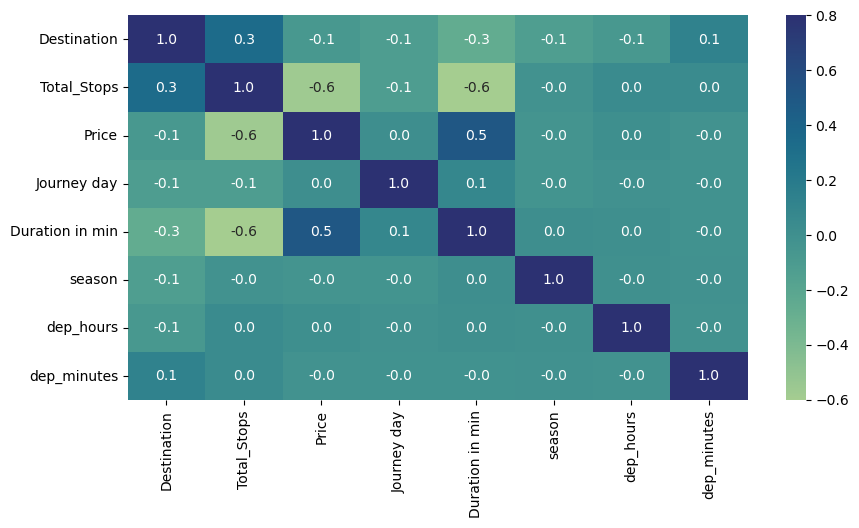

In [24]:
plt.figure(figsize=(10,5))
numeric_cols = df.select_dtypes(include=['number'])
correlations = numeric_cols.corr()

sns.heatmap(correlations,vmin=None,
    vmax=0.8,
    cmap='crest',
    annot=True,
    fmt='.1f',
    linecolor='white',
    cbar=True);

In [25]:
df = df.drop(columns=["Dep_Time","Arrival_Time","Duration","Hours","Min","Date_of_Journey","dep_hours","dep_minutes","season","Source","Journey day","Journey Month","Route"])

In [26]:
df = pd.get_dummies(data = df ,columns=["Airline","Additional_Info"],drop_first=True)

In [27]:
df.head()

,Destination,Total_Stops,Price,Duration in min,Airline_Air India,Airline_GoAir,Airline_IndiGo,Airline_Jet Airways,Airline_Jet Airways Business,Airline_Multiple carriers,...,Airline_Vistara Premium economy,Additional_Info_1 Short layover,Additional_Info_2 Long layover,Additional_Info_Business class,Additional_Info_Change airports,Additional_Info_In-flight meal not included,Additional_Info_No Info,Additional_Info_No check-in baggage included,Additional_Info_No info,Additional_Info_Red-eye flight
0,5,4,3897,170.0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
1,0,1,7662,445.0,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
2,1,1,13882,1140.0,False,False,False,True,False,False,...,False,False,False,False,False,False,False,False,True,False
3,0,0,6218,325.0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,5,0,13302,285.0,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,True,False


In [28]:
X = df.drop(columns=["Price"])
Y = df["Price"]

### Feature importances

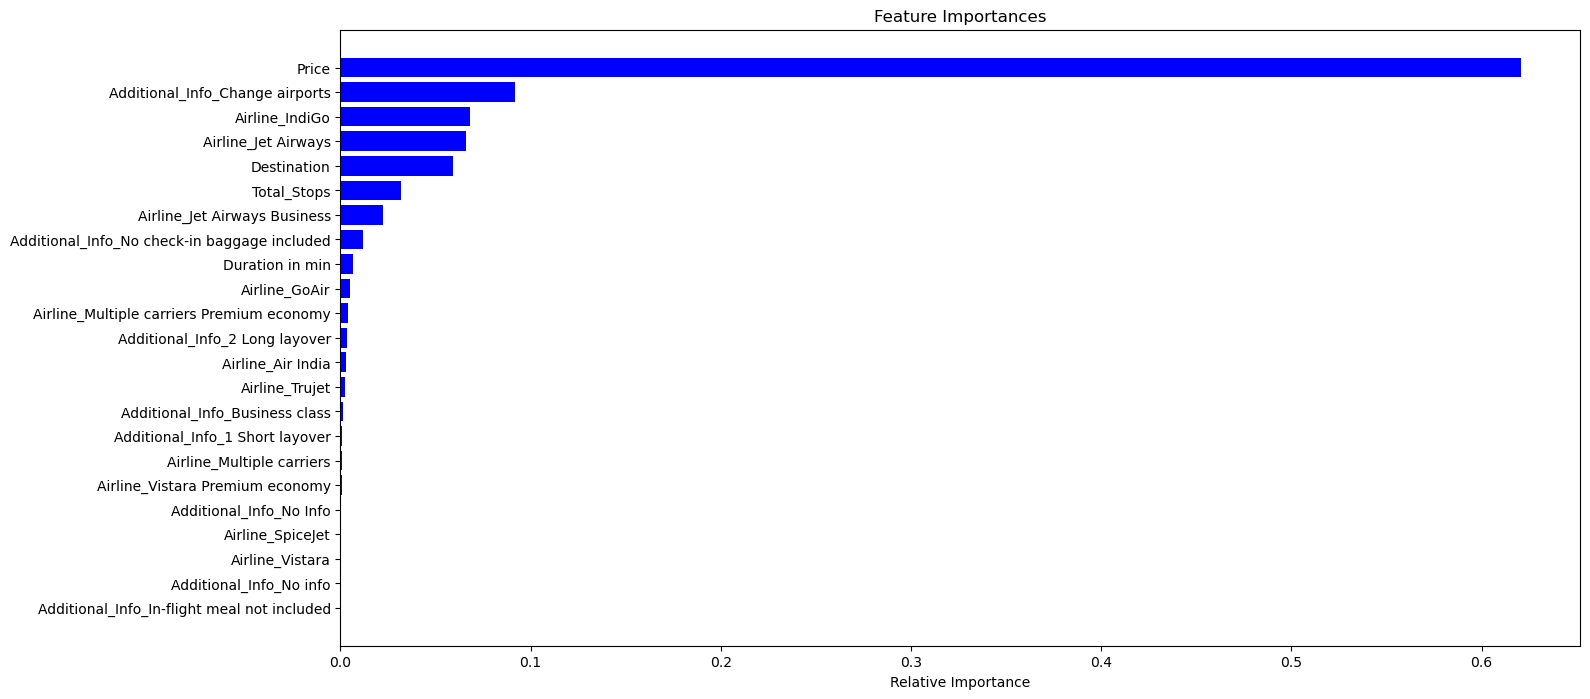

In [29]:
RandomForest = RandomForestRegressor()
RandomForest.fit(X,Y)
features = df.columns
importances = RandomForest.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(16, 8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [38]:
range(len(indices)), [features[i] for i in indices]

(range(0, 23),
 ['Additional_Info_In-flight meal not included',
  'Additional_Info_No info',
  'Airline_Vistara',
  'Airline_SpiceJet',
  'Additional_Info_No Info',
  'Airline_Vistara Premium economy',
  'Airline_Multiple carriers',
  'Additional_Info_1 Short layover',
  'Additional_Info_Business class',
  'Airline_Trujet',
  'Airline_Air India',
  'Additional_Info_2 Long layover',
  'Airline_Multiple carriers Premium economy',
  'Airline_GoAir',
  'Duration in min',
  'Additional_Info_No check-in baggage included',
  'Airline_Jet Airways Business',
  'Total_Stops',
  'Destination',
  'Airline_Jet Airways',
  'Airline_IndiGo',
  'Additional_Info_Change airports',
  'Price'])

In [31]:
X = df.drop(columns=['Additional_Info_In-flight meal not included',
                     'Additional_Info_Business class',
                     'Airline_Multiple carriers',
                     'Airline_Vistara Premium economy',
                     'Additional_Info_1 Short layover',
                     'Additional_Info_No Info',
                     'Airline_Vistara',
                     'Airline_SpiceJet',
                     'Additional_Info_No info'])

# **Machine Learning models**

## Defining MAPE function 

In [32]:
def MAPE(Y_actual,Y_predicted):
    mape = round(np.mean(np.abs((Y_actual - Y_predicted) / Y_actual)) * 100,2)
    return mape

## Linear Models

### Linear regression

In [33]:
x_train, x_test, y_train, y_test = train_test_split(X,Y,test_size=0.2, random_state=42) 
LR = LinearRegression(n_jobs=-1)
LR.fit(x_train,y_train)
y_pred = LR.predict(x_test)
Y_LR_pred = LR.predict(X)

print("MAPE:",MAPE(Y,Y_LR_pred) , "%")
print("MAE:", mean_absolute_error(y_pred, y_test))
print("MSE:", mean_squared_error(y_pred, y_test))
print("r2 score:", round(r2_score(y_pred, y_test)*100,2) , "%")
print("\n________________________________________________\n\n")
k_folds = KFold(n_splits = 9)
scores = cross_val_score(LR, X, Y, cv = k_folds)

print("Cross Validation Scores: ", scores)
print("Number of CV Scores used in Average: ", len(scores))
print("Average CV Score: ", round(scores.mean()*100,2), "%")

MAPE: 0.0 %
MAE: 2.364601105779312e-12
MSE: 1.1946992424565307e-23
r2 score: 100.0 %

________________________________________________


Cross Validation Scores:  [1. 1. 1. 1. 1. 1. 1. 1. 1.]
Number of CV Scores used in Average:  9
Average CV Score:  100.0 %


#### Residuals plot

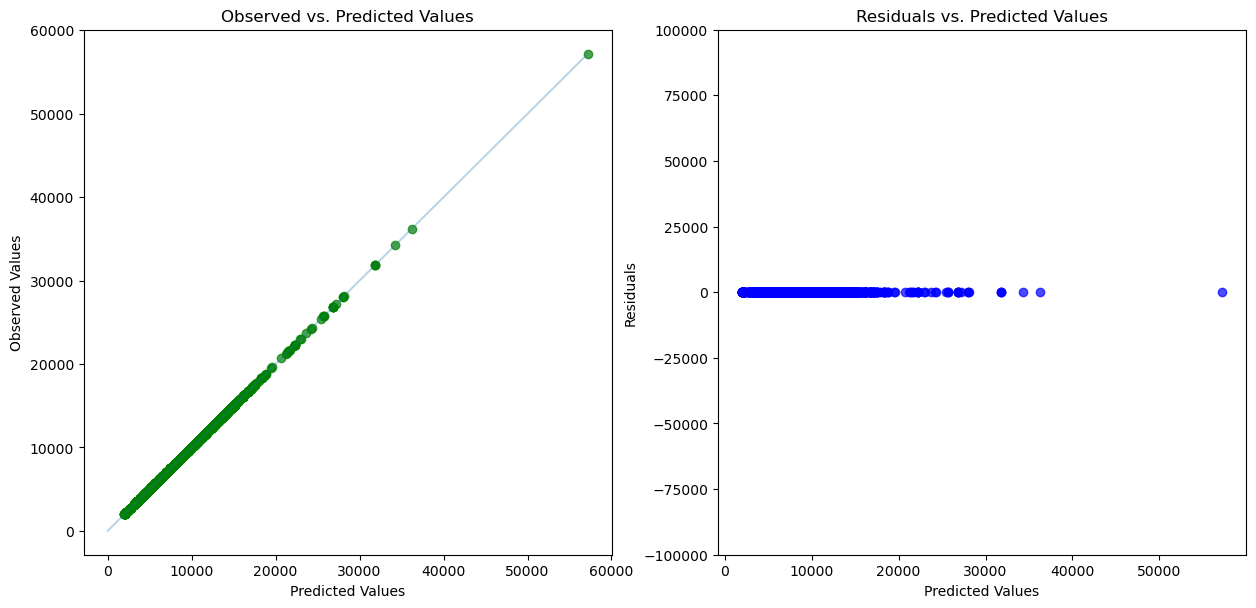

In [34]:
y_pred = LR.predict(x_test)
residuals = y_test - y_pred

plt.figure(figsize=(15, 15))

plt.subplot(2, 2, 1)
plt.scatter(y_pred, y_test, c='green', alpha=0.7)
plt.plot(np.linspace(0, int(y_test.max())), np.linspace(0, int(y_test.max())), alpha= 0.3)
plt.xlabel('Predicted Values')
plt.ylabel('Observed Values')
plt.title('Observed vs. Predicted Values')

ax2= plt.subplot(2, 2, 2)
plt.scatter(y_pred, residuals, c='blue', alpha=0.7)
ax2.set_ylim(-100000, 100000)
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residuals vs. Predicted Values')


plt.show()